In [1]:
import os
import tensorflow as tf
from roboflow import Roboflow
from dotenv import load_dotenv
load_dotenv("labelbox.env")

True

In [ ]:
print(tf.version.VERSION)

# - Load Data

---

### --- Load Labelbox Project

In [2]:
import labelbox
LB_API_KEY = os.getenv("labelbox_soccer")
PROJECT_ID = 'clgmw7co50urt070y3evv6o23'
client = labelbox.Client(api_key = LB_API_KEY)
project = client.get_project(PROJECT_ID)
labels = project.export_v2(params={
"data_row_details": True,
"metadata": True,
"attachments": True,
"project_details": True,
"performance_details": True,
"label_details": True,
"interpolated_frames": True
  })

In [4]:
export_json = labels.result
# print("results: ", export_json)

In [ ]:
## EXPERIMENT - ONLY ##
export_json[0]['data_row']
export_json[0]['projects']['clgmw7co50urt070y3evv6o23']['labels'][0]['annotations']['classifications']

In [5]:
class_dict = {}
for i in export_json:
    class_dict[i['data_row']['external_id']]= i['projects']['clgmw7co50urt070y3evv6o23']['labels'][0]['annotations']['classifications'][0]['radio_answer']['name']

In [6]:
LOCATION = r"C:\Users\yingy\Desktop\Py_personal\Learning\soccer\tf_object_detection\Soccer Object detection.v1i.tfrecord_ignore_data"
# test_record_fname = dataset.location + '/test/cells.tfrecord'
train_record_fname = LOCATION + '/train/people.tfrecord'
raw_dataset = tf.data.TFRecordDataset(train_record_fname)

In [7]:
train_images_dict = {}
for i, raw_record in enumerate(raw_dataset): #.take(1)
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    file_name=example.features.feature['image/filename'].bytes_list.value[0].decode()
    image_encoded_data = example.features.feature['image/encoded'].bytes_list.value[0]
    train_images_dict[file_name.split("_")[0]+'.jpg'] = image_encoded_data

In [8]:
from PIL import Image
import io
import numpy as np

### --- Method 1: Load images and classifications from tfrecord

- Most of the code below are referenced from https://financial-engineering.medium.com/tensorflow-2-0-load-images-to-tensorflow-897b8b067fc2

Might not work with tf1: https://notebook.community/tensorflow/docs/site/en/r1/tutorials/load_data/images 

https://keras.io/api/data_loading/image/

In [9]:
def process_image_label(image_encoded_data, file_name,class_dict):
    label = True if class_dict[file_name] == 'Yes' else False
    imageStream = io.BytesIO(image_encoded_data)
    img = Image.open(imageStream).convert('RGB')
    image_array = np.array(img)
    image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
    return tf.image.resize(image_tensor, [224,224]), label

In [ ]:
image_list = []
label_list = []
for k,v in train_images_dict.items():
    image, label = process_image_label(v,k,class_dict)
    image_list.append(image)
    label_list.append(label)

In [ ]:
labeled_dataset = tf.data.Dataset.from_tensor_slices((image_list,label_list))

In [ ]:
## EXPERIMENT - ONLY ##
for image, label in labeled_dataset.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

### --- Method 2: Load images and classifications from image files
https://www.tensorflow.org/tutorials/images/classification

In [10]:
path =  r"C:\Users\yingy\Desktop\Py_personal\Learning\soccer\tf_object_detection\Soccer Object detection.v1i.tfrecord_ignore_data\training_data"
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)
    os.makedirs(path+"\True")
    os.makedirs(path+"\False")

In [11]:
def gen_image_lable(image_encoded_data, file_name,class_dict):
    label = True if class_dict[file_name] == 'Yes' else False
    imageStream = io.BytesIO(image_encoded_data)
    img = Image.open(imageStream).convert('RGB')
    return img, label

In [13]:
for k,v in train_images_dict.items():
    image, label = gen_image_lable(v,k,class_dict)
    if label:
        image.save(path+"\True"+"\\"+k)
    else:
        image.save(path+"\False"+"\\"+k)

In [14]:
import pathlib
data_dir = pathlib.Path(path)

In [15]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

199


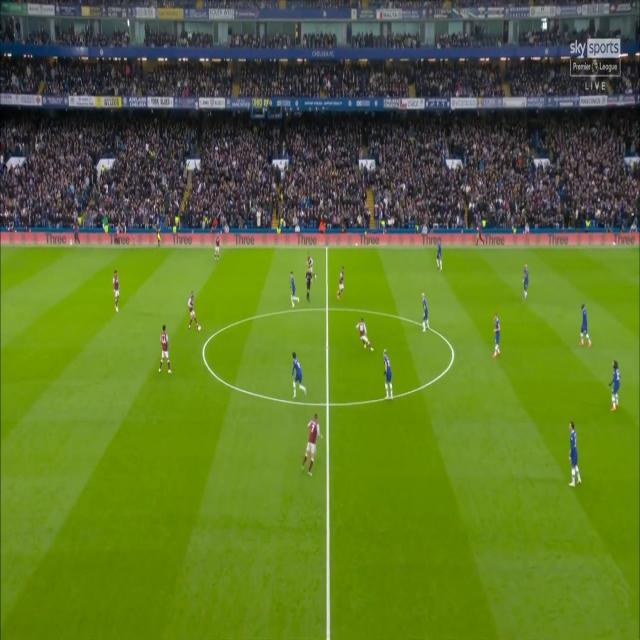

In [17]:
roses = list(data_dir.glob('True/*'))
Image.open(str(roses[0]))

### --- Method 1: Prepare for Training

In [ ]:
BATCH_SIZE = 32
AUTOTUNE=tf.data.experimental.AUTOTUNE

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat() #repeat forever
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [ ]:
train_ds = prepare_for_training(labeled_dataset)

In [ ]:
## EXPERIMENT - ONLY ##
import matplotlib.pyplot as plt
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n].astype("uint8"))
        plt.title(label_batch[n])
        plt.axis('off')

    return plt.show()
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
from tensorflow.keras import layers
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
## EXPERIMENT - ONLY ##
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

In [ ]:
## EXPERIMENT - ONLY ##
print(first_image.shape)
import matplotlib.pyplot as plt
# Set number of characters per row when printing
np.set_printoptions(linewidth=320)
# Visualize the image
plt.imshow(first_image)

### --- Method 2: Prepare for Training

In [18]:
batch_size = 32
img_height = 224
img_width = 224

In [19]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 199 files belonging to 2 classes.
Using 160 files for training.


In [20]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 199 files belonging to 2 classes.
Using 39 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['False', 'True']


In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
from tensorflow.keras import layers
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### --- Model Construction & Training

In [25]:
from tensorflow import keras
num_classes = 2
model = keras.models.Sequential([keras.layers.Flatten(input_shape=(224,224,3)),  
        keras.layers.Dense(128, activation=tf.nn.relu), # 128 neurons in the middle layer
        keras.layers.Dense(num_classes, activation=tf.nn.softmax)])

In [26]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Method 1
model.fit(normalized_ds, epochs=8)

In [27]:
# Method 2
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
5/5 [==============================] - 2s 209ms/step - loss: 13354.1250 - accuracy: 0.5625 - val_loss: 3705.4543 - val_accuracy: 0.6923
Epoch 2/10
5/5 [==============================] - 1s 125ms/step - loss: 3166.3557 - accuracy: 0.5063 - val_loss: 153.0587 - val_accuracy: 0.8974
Epoch 3/10
5/5 [==============================] - 1s 114ms/step - loss: 806.2372 - accuracy: 0.8188 - val_loss: 175.7594 - val_accuracy: 0.9231
Epoch 4/10
5/5 [==============================] - 1s 141ms/step - loss: 346.0322 - accuracy: 0.8813 - val_loss: 454.4034 - val_accuracy: 0.8462
Epoch 5/10
5/5 [==============================] - 1s 122ms/step - loss: 177.3856 - accuracy: 0.9438 - val_loss: 200.6228 - val_accuracy: 0.9231
Epoch 6/10
5/5 [==============================] - 1s 127ms/step - loss: 189.4005 - accuracy: 0.9375 - val_loss: 6.8477 - val_accuracy: 0.9744
Epoch 7/10
5/5 [==============================] - 1s 135ms/step - loss: 46.9440 - accuracy: 0.9563 - val_loss: 91.6052 - val_accuracy:

In [29]:
# Build a simple prediction service 
import numpy as np
from tensorflow.keras.preprocessing import image
file_name = "WebImagetest-Yes.jpg"
uploaded = {file_name:0}

for fn in uploaded.keys():
    path =  fn
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes)

    if classes[0][0]>0.5:
        print(fn + " is a sideline angle")
    else:
        print(fn + " is not a sideline angle")

1/1 [==============================] - 0s 41ms/step
[[1.0000000e+00 1.4057795e-14]]
WebImagetest-Yes.jpg is a sideline angle


### --- Load Roboflow Project with image annotation data

In [ ]:
RF_KEY = os.getenv("rb_key")
rf = Roboflow(api_key=RF_KEY)
project = rf.workspace("personal-y96vs").project("soccer-object-detection-yj7hm")
# dataset = project.version(1).download("tensorflow")

In [ ]:
# dataset.location = r"C:\Users\yingy\Desktop\Py_personal\Learning\soccer\tf_object_detection\Soccer Object detection.v1i.tfrecord_ignore_data"
# LOCATION = dataset.location
LOCATION = r"C:\Users\yingy\Desktop\Py_personal\Learning\soccer\tf_object_detection\Soccer Object detection.v1i.tfrecord_ignore_data"
print("location:", LOCATION)
# CLASSES = sorted(project.classes.keys())
# print("classes:", CLASSES)

In [ ]:
# test_record_fname = dataset.location + '/test/cells.tfrecord'
train_record_fname = LOCATION + '/train/people.tfrecord'
label_map_pbtxt_fname = LOCATION + '/train/people_label_map.pbtxt'

In [ ]:
raw_dataset = tf.data.TFRecordDataset(train_record_fname)

In [ ]:
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
#     print(example.features.feature)
    print(example)

In [ ]:
type(raw_dataset)

# - Plot an image with label

---
Reference: 
https://www.kaggle.com/code/mistag/tensorflow-tfrecords-demystified

In [ ]:
img_example = next(iter(raw_dataset)) 
img_parsed = tf.train.Example.FromString(img_example.numpy())
# only extract features we will actually use
xmin=img_parsed.features.feature['image/object/bbox/xmin'].float_list.value[:]
xmax=img_parsed.features.feature['image/object/bbox/xmax'].float_list.value[:]
ymin=img_parsed.features.feature['image/object/bbox/ymin'].float_list.value[:]
ymax=img_parsed.features.feature['image/object/bbox/ymax'].float_list.value[:]
file_name=img_parsed.features.feature['image/filename'].bytes_list.value[0].decode()
classes=img_parsed.features.feature['image/object/class/text'].bytes_list.value[:]
class_label=img_parsed.features.feature['image/object/class/label'].int64_list.value[:]
img_encoded=img_parsed.features.feature['image/encoded'].bytes_list.value[0]

In [ ]:
file_name

In [ ]:
def bbox(img, xmin, ymin, xmax, ymax, width, label, score):
    draw = ImageDraw.Draw(img)
    xres, yres = img.size[0], img.size[1]
    box = np.multiply([xmin, ymin, xmax, ymax], [xres, yres, xres, yres]).astype(int).tolist()
    txt = " {}: {}%" if score >= 0. else " {}"
    txt = txt.format(label, round(score, 1))
    ts = draw.textbbox((len(txt)*6,8), txt)
    draw.rectangle(box, width=width)
    if len(label) > 0:
        if box[1] >= ts[1]+3:
            xsmin, ysmin = box[0], box[1]-ts[1]-3
            xsmax, ysmax = box[0]+ts[0]+2, box[1]
        else:
            xsmin, ysmin = box[0], box[3]
            xsmax, ysmax = box[0]+ts[0]+2, box[3]+ts[1]+1
        draw.rectangle([xsmin, ysmin, xsmax, ysmax],width = 1)
        draw.text((xsmin, ysmin), txt, fill='white')

def plot_img(img, axes, xmin, ymin, xmax, ymax, classes, class_label):
    for i in range(len(xmin)):
        bbox(img, xmin[i], ymin[i], xmax[i], ymax[i], 2, classes[i].decode(), -1)
    plt.setp(axes, xticks=[], yticks=[])
    plt.imshow(img)

In [ ]:
import numpy as np
from io import BytesIO
from PIL import Image, ImageFont, ImageDraw
fig = plt.figure(figsize=(20,20))
axes = axes = fig.add_subplot(1, 1, 1)
img = Image.open(BytesIO(img_encoded))
plot_img(img, axes, xmin, ymin, xmax, ymax, classes, class_label)

In [ ]:
# Create a dictionary describing the features.
image_feature_description = {
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin':  tf.io.VarLenFeature( tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/filename': tf.io.VarLenFeature(tf.string),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_dataset.map(_parse_image_function)
parsed_image_dataset

In [ ]:
import IPython.display as display
for image_features in parsed_image_dataset.take(1):
    image_raw = image_features['image/encoded'].numpy()
    display.display(display.Image(data=image_raw))

In [ ]:
for i, raw_record in enumerate(raw_dataset.take(1)):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    info = {}
    info['image/encoded'] = example.features.feature['image/encoded'].bytes_list.value[0]

In [ ]:
import io
from PIL import Image

imageStream = io.BytesIO(info['image/encoded'])
imageFile = Image.open(imageStream)
display(imageFile)

# References

https://www.tensorflow.org/guide/data#consuming_tfrecord_data

[How to Train YOLO-NAS on a Custom Dataset](https://blog.roboflow.com/yolo-nas-how-to-train-on-custom-dataset/): [Notebook](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolo-nas-on-custom-dataset.ipynb?ref=blog.roboflow.com#scrollTo=sGBOHyPc11LA)

[Read tfrecord dataset for images](https://www.tensorflow.org/tutorials/load_data/tfrecord)